# Permutation_importance

`permutation_importance` é uma técnica usada para avaliar a importância das features em um modelo de aprendizado de máquina. Ela é usada para determinar a influência relativa de cada feature nas previsões feitas pelo modelo. A ideia principal por trás do `permutation_importance` é medir o impacto de embaralhar aleatoriamente os valores de uma feature sobre o desempenho do modelo, a fim de avaliar quanto a métrica de avaliação (por exemplo, precisão, R²) é afetada por essas mudanças.

**Cálculo da Métrica Base:** Primeiro, o modelo é treinado com os dados de treinamento e a métrica de avaliação (por exemplo, precisão, R²) é calculada no conjunto de teste. Isso fornece a métrica de desempenho base do modelo.

**Embaralhamento das Features:** Em seguida, cada feature é embaralhada aleatoriamente nos dados de teste, mantendo as outras features inalteradas. Isso significa que os valores de uma feature são misturados aleatoriamente em relação aos rótulos reais.

**Cálculo da Métrica Após Embaralhamento:** O modelo treinado com as features embaralhadas é usado para fazer previsões no conjunto de teste. A mesma métrica de avaliação é calculada novamente usando as previsões feitas com as features embaralhadas.

**Comparação de Métricas:** A diferença entre a métrica de desempenho base (etapa 1) e a métrica de desempenho após o embaralhamento (etapa 3) é calculada para cada feature. Quanto maior a diferença, mais importante é a feature para o modelo. Se a métrica cair significativamente após o embaralhamento, isso sugere que a feature é importante.

In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

In [21]:
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

In [24]:
X, y = make_classification(n_samples=5_000, n_features=5)
X = pd.DataFrame(X, columns=['A', 'B', 'C', 'D', 'E'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [30]:
clf = RandomForestClassifier(max_depth=4, random_state=42)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))

Accuracy on test data: 0.93


In [31]:
result = permutation_importance(clf, X_train, y_train, n_repeats=15, random_state=42)

In [32]:
perm_sorted_idx = result.importances_mean.argsort()

In [33]:
perm_sorted_idx

array([1, 2, 3, 0, 4], dtype=int64)

In [35]:
tree_importance_sorted_idx = np.argsort(clf.feature_importances_)

In [36]:
tree_importance_sorted_idx

array([1, 3, 2, 0, 4], dtype=int64)

In [37]:
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

In [38]:
tree_indices

array([0.5, 1.5, 2.5, 3.5, 4.5])

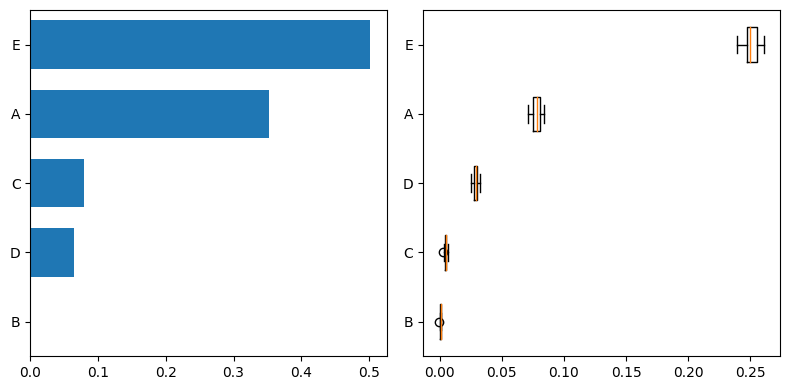

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(X.columns[tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=X.columns[perm_sorted_idx],
)

fig.tight_layout()
plt.show()

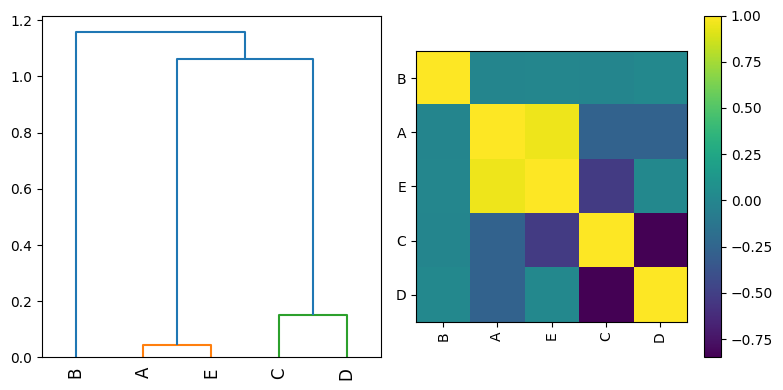

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
corr = spearmanr(X).correlation
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=X.columns, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))
im = ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.colorbar(im, ax=ax2)
fig.tight_layout()
plt.show()

In [60]:
cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

In [62]:
X_train_sel = X_train.iloc[:, selected_features]
X_test_sel = X_test.iloc[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print(
    "Accuracy on test data with features removed: {:.2f}".format(
        clf_sel.score(X_test_sel, y_test)
    )
)

Accuracy on test data with features removed: 0.94


##### features correlacionadas em cada cluster
**A: 0**  
**B: 1**  
**C: 2**  
**D: 3**  
**E: 4**  
As features [A: 0, E:4] e [C:2, D:3] são correlacionadas já a feature B:1 não esta correlacionada com ninguém

In [65]:
cluster_id_to_feature_ids.values()

dict_values([[0, 4], [1], [2, 3]])

In [66]:
# Cuidado, a feature E é melhor que a A mas aqui nos deixamos a A e removemos a E
selected_features

[0, 1, 2]

In [68]:
X_train_sel = X_train.iloc[:, [4,3]]
X_test_sel = X_test.iloc[:, [4,3]]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print(
    "Accuracy on test data with features removed: {:.2f}".format(
        clf_sel.score(X_test_sel, y_test)
    )
)

Accuracy on test data with features removed: 0.94
